<h1>1. Loading and analyzing the dataset structure.</h1>

<h2>Imports</h2>

In [2]:
import pandas as pd
import seaborn as sns
import missingno as msg
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif

<h2>Functions</h2>

In [3]:
def frequency_encoder(df, column_names: list):
    '''
    DESCRIPTION:
    This function encodes categorical columns in a DataFrame by their frequency counts. 
    It replaces the original categorical values with the frequency of each category.

    ARGUMENTS:
    df : pandas.DataFrame
        The DataFrame containing the columns to be encoded.
    column_names : list
        A list of column names (strings) to be encoded.

    RETURN:
    pandas.DataFrame
        The DataFrame with the specified columns encoded by frequency counts.
    '''
    for column_name in column_names:
        df[column_name] = df[column_name].map(df[column_name].value_counts())
    return df

<h2>Constants</h2>

In [4]:
charts_font_config = {
    'title':{'size':20, 'color': 'black'},
    'label': {'size':15, 'color': 'black'}
    }
charts_figsize_config = (10, 6)
charts_palette_color = 'viridis'

<h2>Classes</h2>

In [5]:
'''
Pandas configuration
'''

pd.set_option('display.max_columns', None)

In [6]:
'''
Data load.
'''

df = pd.read_csv('insurance_data.csv')

In [7]:
'''
Dataframe aspect.
'''
df.head(3)

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585  10/17/2014 0:00           OH   
1                 228   42         342868   6/27/2006 0:00           IN   
2                 134   29         687698    9/6/2000 0:00           OH   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   

   insured_zip insured_sex insured_education_level insured_occupation  \
0       466132        MALE                      MD       craft-repair   
1       468176        MALE                      MD  machine-op-inspct   
2       430632      FEMALE                     PhD              sales   

  insured_hobbies insured_relationship  capital-gains  capital-loss  \
0        sleeping              husband          53300             0   
1         reading       other-relative              0             0   
2     board-games            own-child          35100             0   

    incident_date             incident_type  collision_type incident_severity  \
0  1/25/2015 0:00  Single Vehicle Collision  Side Collision      Major Damage   
1  1/21/2015 0:00             Vehicle Theft               ?      Minor Damage   
2  2/22/2015 0:00   Multi-vehicle Collision  Rear Collision      Minor Damage   

  authorities_contacted incident_state incident_city  incident_location  \
0                Police             SC      Columbus     9935 4th Drive   
1                Police             VA     Riverwood       6608 MLK Hwy   
2                Police             NY      Columbus  7121 Francis Lane   

   incident_hour_of_the_day  number_of_vehicles_involved property_damage  \
0                         5                            1             YES   
1                         8                            1               ?   
2                         7                            3              NO   

   bodily_injuries  witnesses police_report_available  total_claim_amount  \
0                1          2                     YES               71610   
1                0          0                       ?                5070   
2                2          3                      NO               34650   

   injury_claim  property_claim  vehicle_claim auto_make auto_model  \
0          6510           13020          52080      Saab        92x   
1           780             780           3510  Mercedes       E400   
2          7700            3850          23100     Dodge        RAM   

   auto_year fraud_reported  
0       2004              Y  
1       2007              Y  
2       2007              N

In [8]:
'''
Original data types.
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [9]:
'''
Give date type to columns with dates.
'''

df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])


<Axes: >

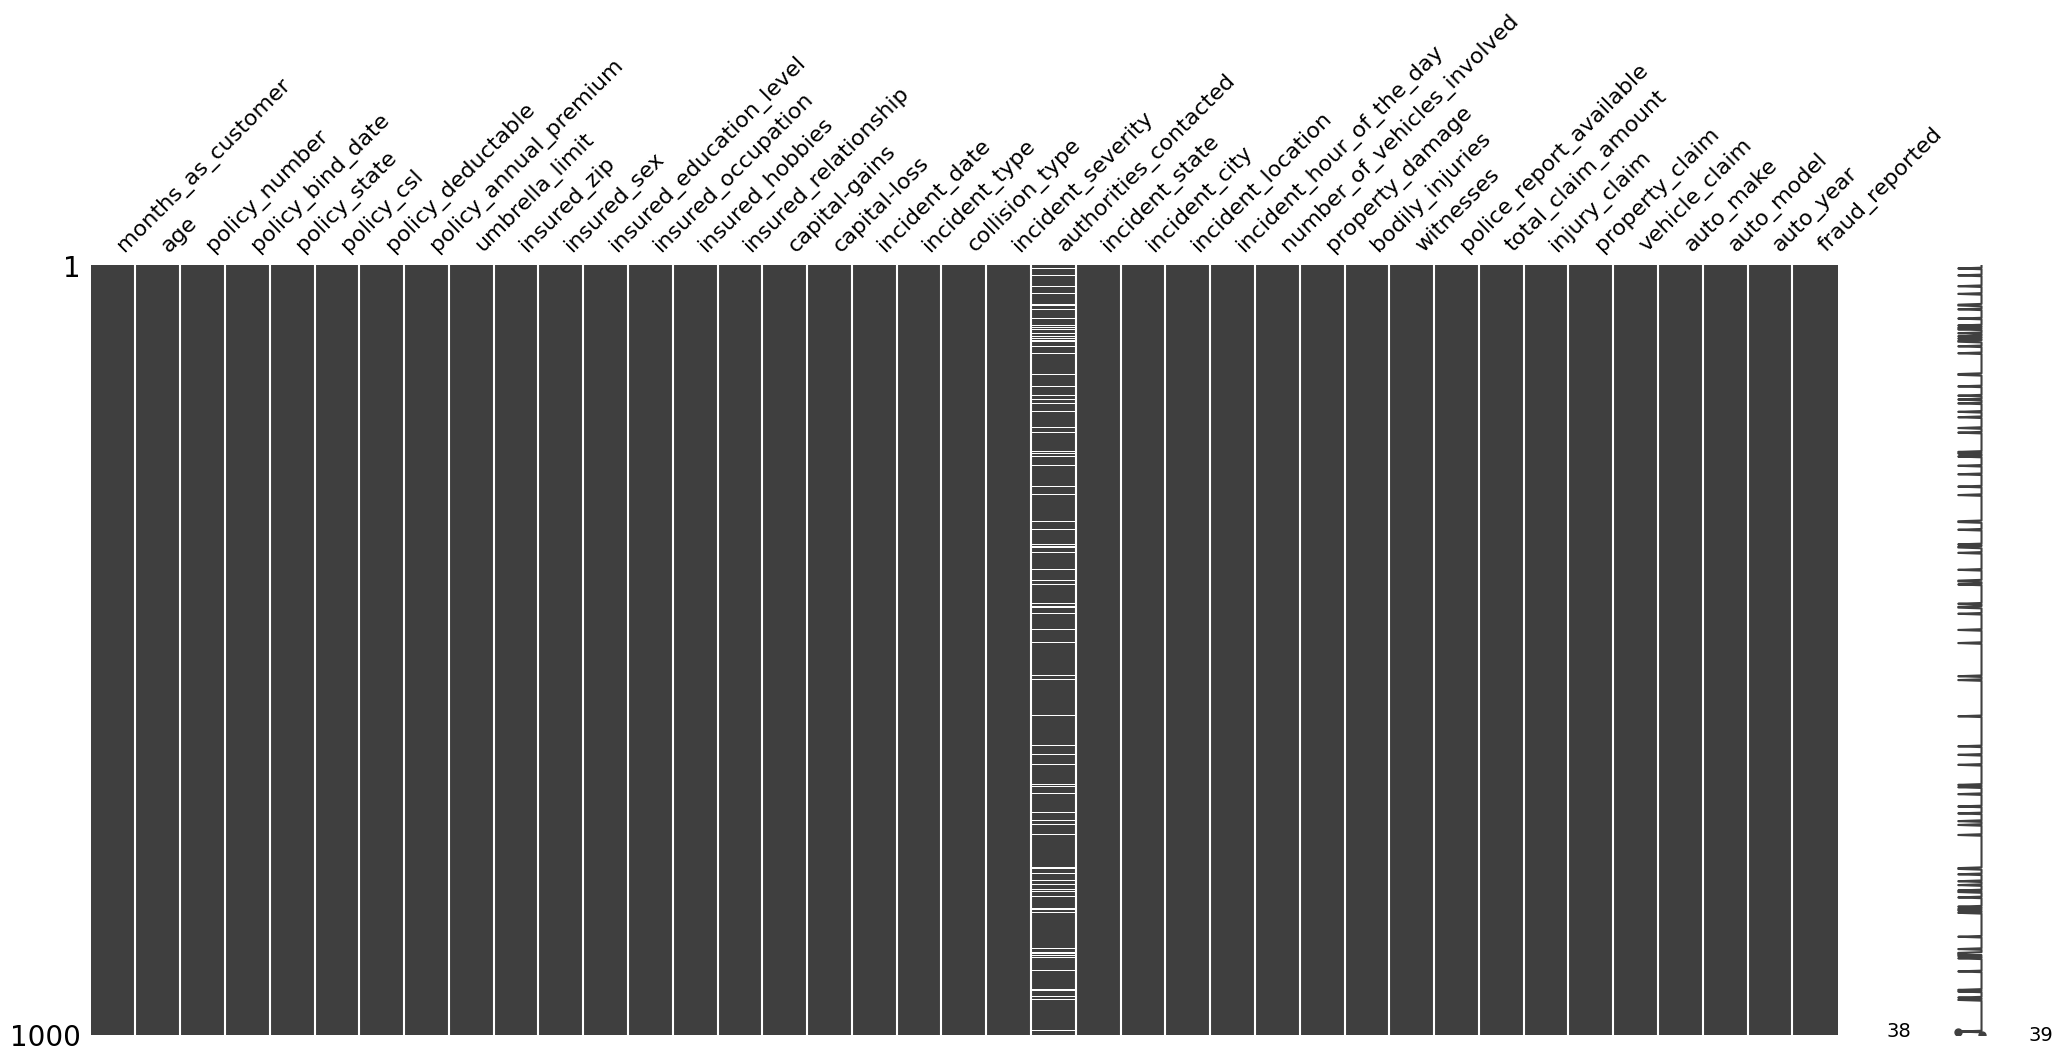

In [10]:
'''
Missing data visualization.
'''

msg.matrix(df)

In [11]:
'''
Missing data count per variable.
'''

df.isna().sum()

months_as_customer              0
age                             0
policy_number                   0
policy_bind_date                0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
umbrella_limit                  0
insured_zip                     0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses     

In [12]:
df = df.dropna(subset=['authorities_contacted']).reset_index(drop=True)

<h3>Note: The column 'authorities_contacted' was the only one with NaN values. I decided to drop the corresponding rows entirely to avoid introducing bias into the dataset, which could have occurred if I had filled the NaN values with the most frequent value or the mean of the column. The sacrifice was 9.1% of the data.</h3>

In [13]:
'''
Replacing the "?" characters by "Unknown" value.
'''
df = df.replace({'?': 'Unknown'})


'''
Spliting column variable "policy_csl" into 
"policy_csl_min" and "policy_csl_max".
'''
df[['policy_csl_min', 'policy_csl_max']] = df['policy_csl'].str.split('/', expand=True)
df = df.drop('policy_csl', axis=1)


'''
Replacing values for Boolean values.
'''
df['insured_sex'] = pd.get_dummies(df['insured_sex'], drop_first=True).astype(int)
df['fraud_reported'] = pd.get_dummies(df['fraud_reported'], drop_first=True).astype(int)


'''
Creating a new variable column with just the zip code of the address written
on the "incident_location" column, which is removed from the dataframe then.
'''
df['incident_zip'] = df['incident_location'].str.split(' ').str[0]
df = df.drop('incident_location', axis=1)


'''
Convert the dates of "policy_bind_date" variable column to timestamp days.
Convert the dates of "incident_date" variable column to timestamp days.
'''
df['policy_bind_date_timestamp'] = (df['policy_bind_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
df['incident_date_timestamp'] = (df['incident_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

'''
Creating columns with each value of the date in the columns 
"policy_bind_date" and "incident_date".
'''
df = df.assign(
    policy_bind_date_day=df['policy_bind_date'].dt.day,
    policy_bind_date_month=df['policy_bind_date'].dt.month,
    policy_bind_date_year=df['policy_bind_date'].dt.year
)

df = df.assign(
    incident_date_day = df['incident_date'].dt.day,
    incident_date_month = df['incident_date'].dt.month,
    incident_date_year = df['incident_date'].dt.year
)

df = df.drop('policy_bind_date', axis=1)
df = df.drop('incident_date', axis=1)

In [14]:
'''
Creating a dictionary with the frequency of each category 
in the columns to be encoded.
'''

columns_to_encode = [
    'policy_state',
    'insured_education_level',
    'insured_occupation',
    'insured_hobbies',
    'insured_relationship',
    'incident_type',
    'collision_type',
    'incident_severity',
    'authorities_contacted',
    'incident_state',
    'incident_city',
    'property_damage',
    'police_report_available',
    'auto_make',
    'auto_model'
]

frequency_map = {column_name:df[column_name].value_counts().to_dict() for column_name in columns_to_encode }

In [15]:
for column_name in columns_to_encode:
    df[column_name] = df[column_name].map(frequency_map[column_name])

In [16]:
'''
View of the dataframe after basic transformations.
'''

df.head(5)

months_as_customer  age  policy_number  policy_state  policy_deductable  \
0                 328   48         521585           319               1000   
1                 228   42         342868           280               2000   
2                 134   29         687698           319               2000   
3                 256   41         227811           310               2000   
4                 256   39         104594           319               1000   

   policy_annual_premium  umbrella_limit  insured_zip  insured_sex  \
0                1406.91               0       466132            1   
1                1197.22         5000000       468176            1   
2                1413.14         5000000       430632            0   
3                1415.74         6000000       608117            0   
4                1351.10               0       478456            0   

   insured_education_level  insured_occupation  insured_hobbies  \
0                      132                  70               38   
1                      132                  87               58   
2                      115                  70               43   
3                      115                  59               43   
4                      115                  71               52   

   insured_relationship  capital-gains  capital-loss  incident_type  \
0                   156          53300             0            403   
1                   164              0             0             53   
2                   165          35100             0            419   
3                   129          48900        -62400            403   
4                   129              0             0            419   

   collision_type  incident_severity  authorities_contacted  incident_state  \
0             276                276                    292             225   
1              87                304                    292              96   
2             292                304                    292             246   
3             254                276                    292              20   
4             292                276                    223             225   

   incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
0            141                         5                            1   
1            121                         8                            1   
2            141                         7                            3   
3            129                         5                            1   
4            129                        19                            3   

   property_damage  bodily_injuries  witnesses  police_report_available  \
0              276                1          2                      286   
1              329                0          0                      316   
2              304                2          3                      307   
3              329                1          2                      307   
4              304                0          2                      307   

   total_claim_amount  injury_claim  property_claim  vehicle_claim  auto_make  \
0               71610          6510           13020          52080         72   
1                5070           780             780           3510         60   
2               34650          7700            3850          23100         72   
3               63400          6340            6340          50720         66   
4               64100          6410            6410          51280         72   

   auto_model  auto_year  fraud_reported policy_csl_min policy_csl_max  \
0          24       2004               1            250            500   
1          24       2007               1            250            500   
2          40       2007               0            100            300   
3          22       2014               1            250            500   
4          25       2003               1         

In [17]:
'''
Getting correlations table.
'''

corr = df.corr()

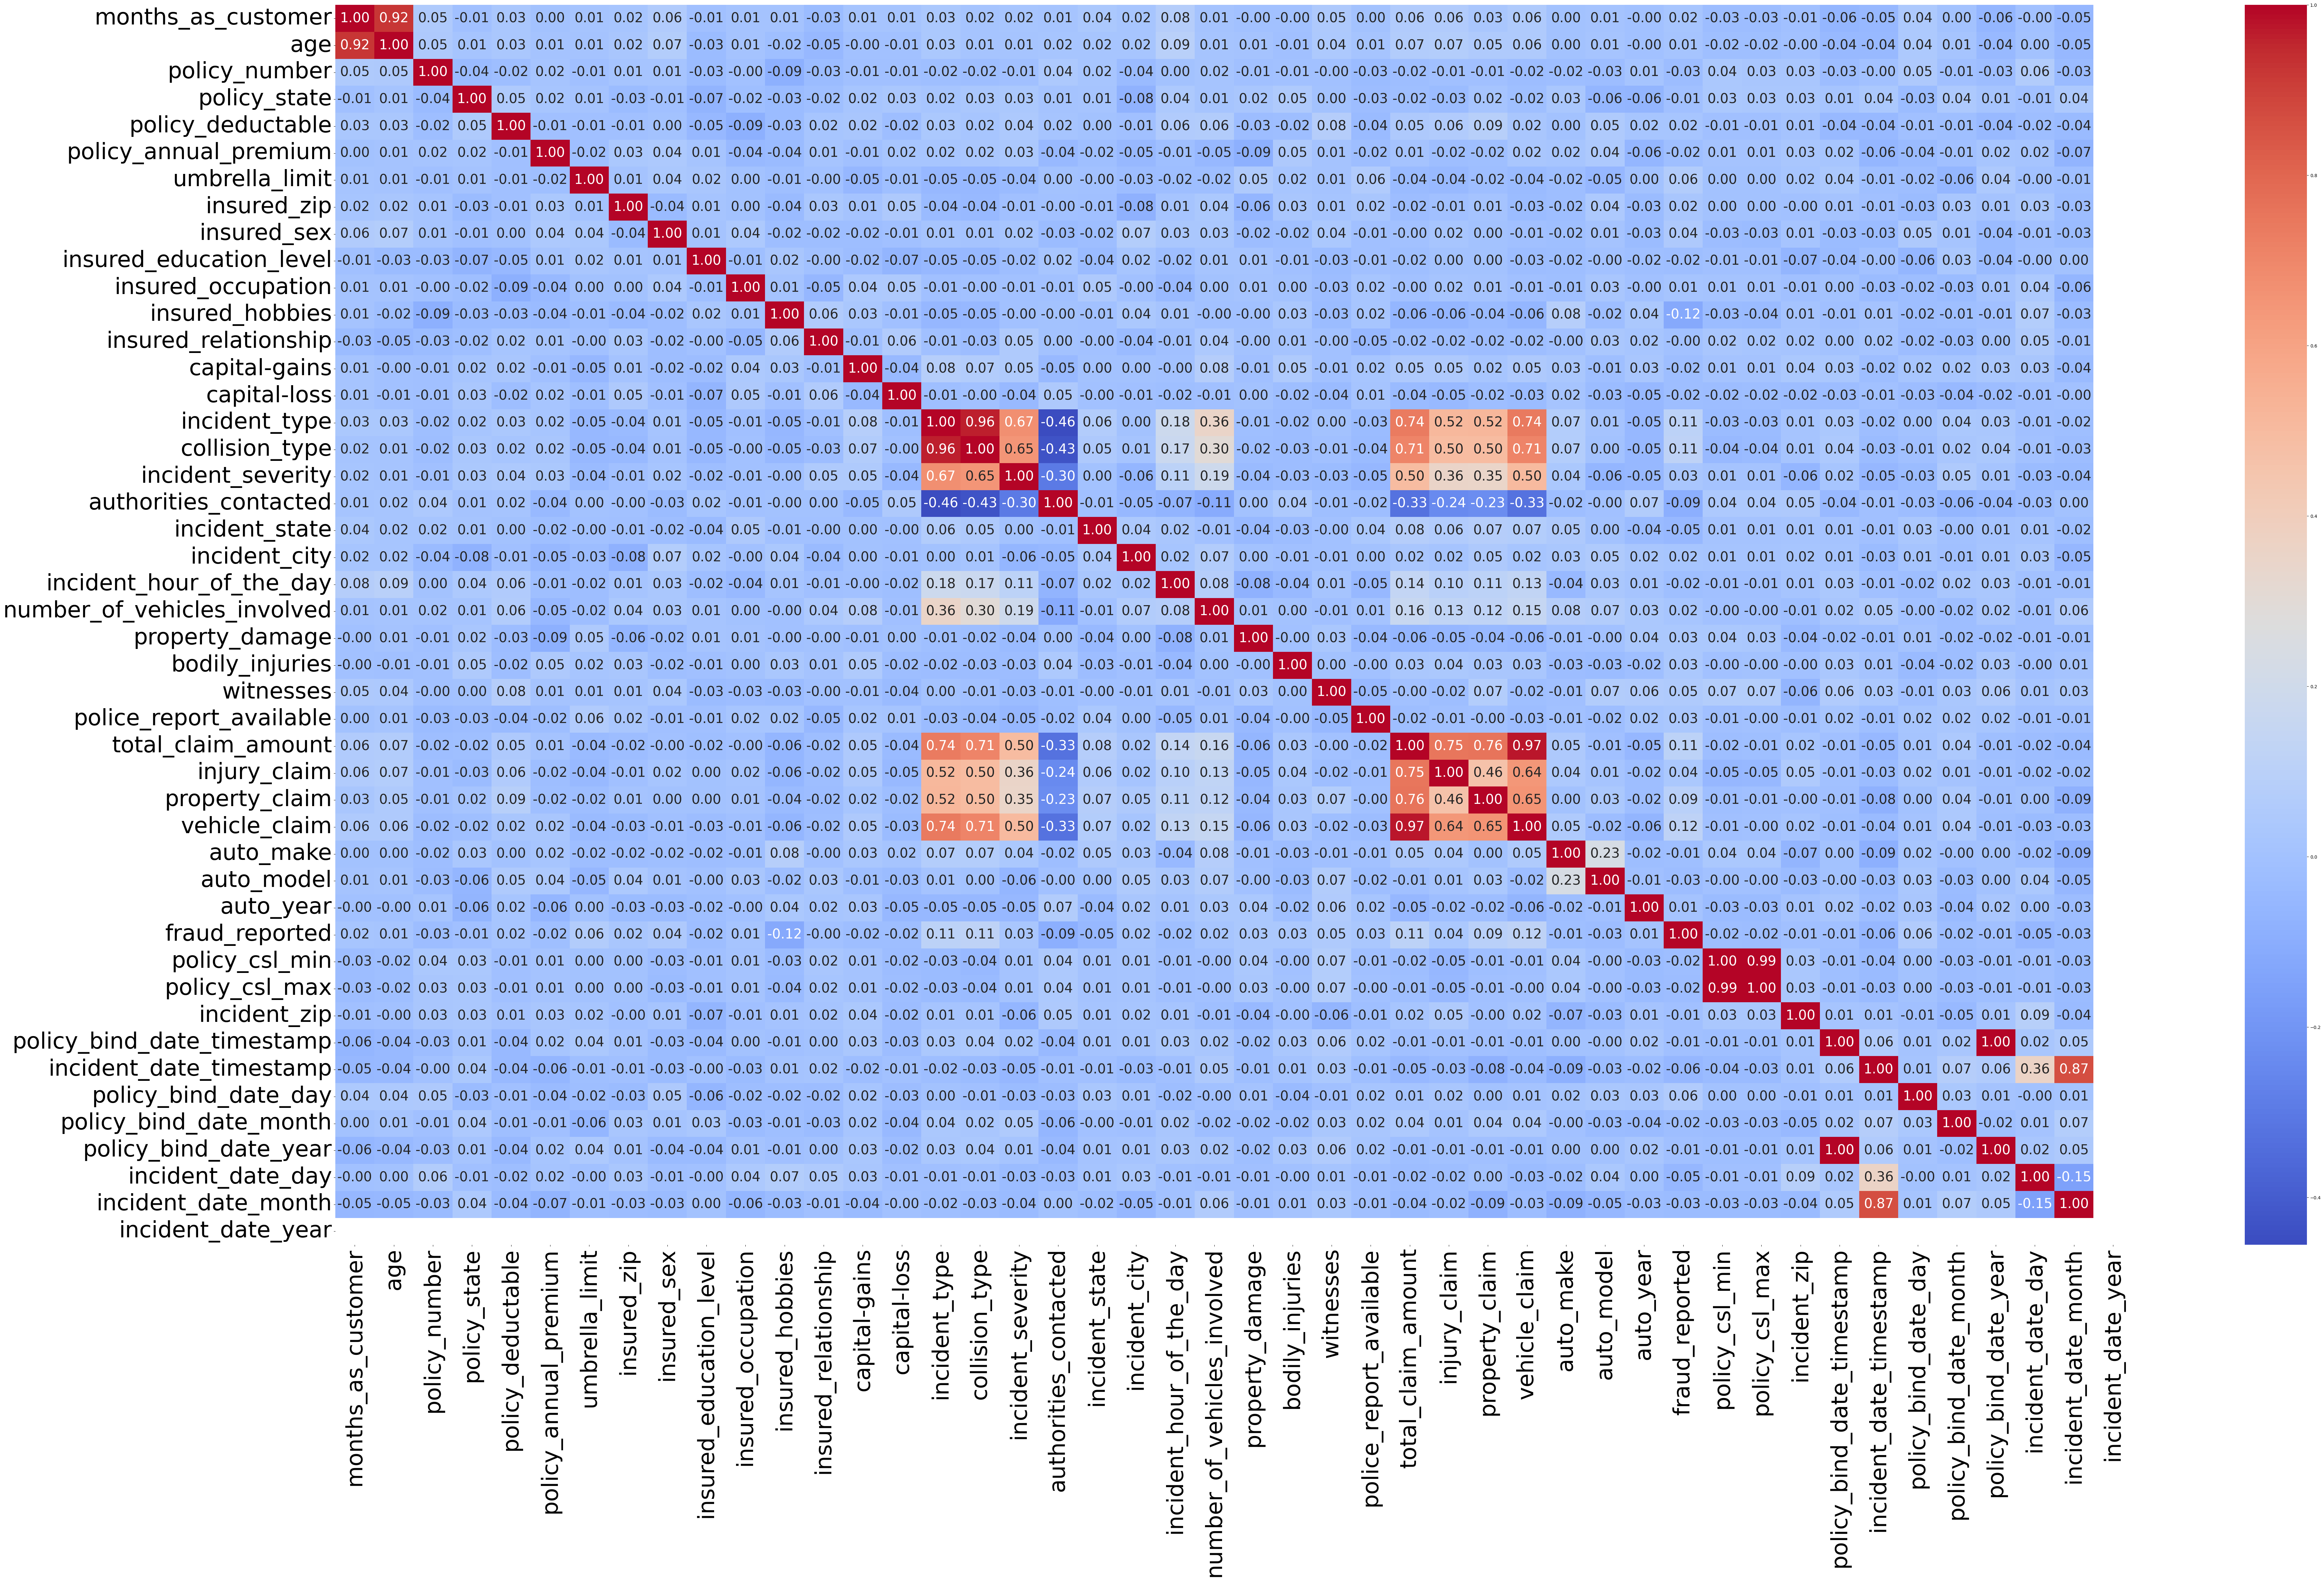

In [18]:
plt.figure(figsize=(90, 50))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 30})
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.show()


In [19]:
corr['fraud_reported'].sort_values(ascending=False)

fraud_reported                 1.000000
vehicle_claim                  0.117877
collision_type                 0.114525
total_claim_amount             0.110167
incident_type                  0.108951
property_claim                 0.091455
umbrella_limit                 0.064335
policy_bind_date_day           0.059763
witnesses                      0.051339
insured_sex                    0.044894
injury_claim                   0.038400
bodily_injuries                0.034726
property_damage                0.033929
police_report_available        0.030313
incident_severity              0.026358
insured_zip                    0.022950
months_as_customer             0.018345
number_of_vehicles_involved    0.018269
policy_deductable              0.017593
incident_city                  0.016788
insured_occupation             0.014982
age                            0.011174
auto_year                      0.009445
insured_relationship          -0.004422
policy_state                  -0.006556


<h3>The correlation table does not show significant relevance between the target variable "fraud_reported" and the other variables in the dataframe. Further techniques will be necessary to gain insights into fraud detection.</h3>

<h1>2. Exploratory Data Analysis (EDA).</h1>

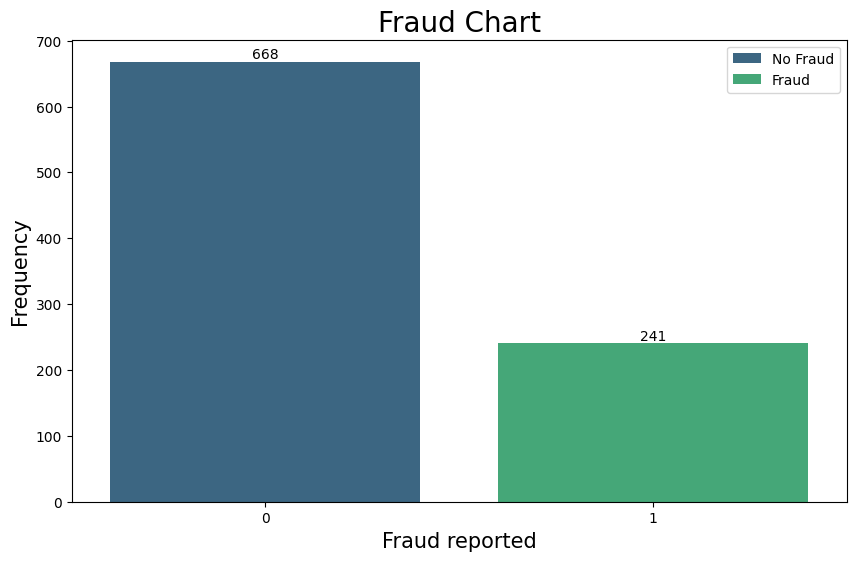

In [20]:
plt.figure(figsize=charts_figsize_config)
ax = sns.countplot(data=df, x='fraud_reported', palette='viridis', hue='fraud_reported' )
plt.xlabel('Fraud reported', fontdict=charts_font_config['label'])
plt.ylabel('Frequency', fontdict=charts_font_config['label'])
plt.title('Fraud Chart', fontdict=charts_font_config['title'])
plt.legend(['No Fraud', 'Fraud'])

for container in ax.containers:
    ax.bar_label(container)

Text(0.5, 1.0, 'Percentage of Frauds')

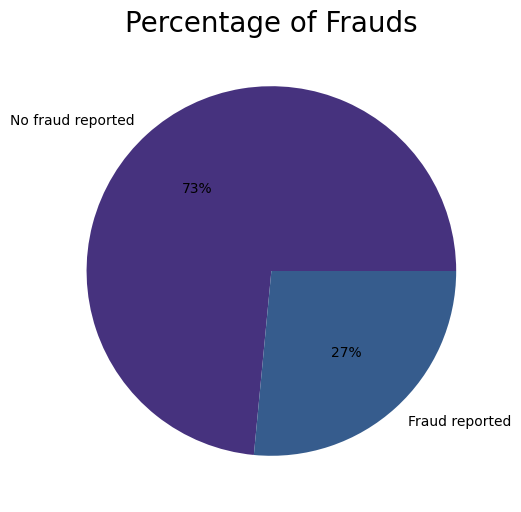

In [21]:
'''
Ploting percentage of frouds and non frouds reported.
'''

figure = plt.figure(figsize=charts_figsize_config)

plt.pie(df['fraud_reported'].value_counts(), labels=['No fraud reported', 'Fraud reported'], autopct='%.0f%%', colors=sns.color_palette(charts_palette_color))
plt.title('Percentage of Frauds', fontdict=charts_font_config['title'])

/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/1675682984.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=claims, x='Claim Type', y='Total', palette='viridis')


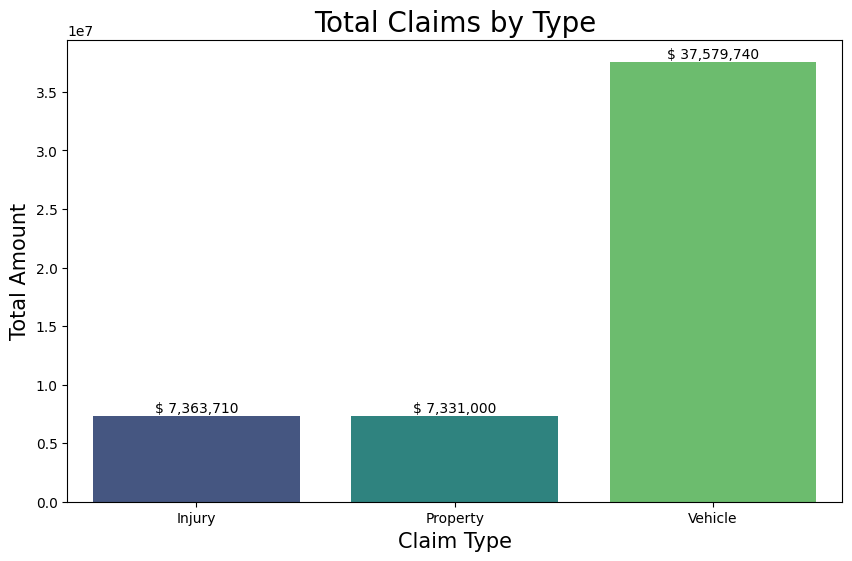

In [22]:
'''
Ploting total of claim amount per type of accident.
'''

injury_claim_total = df['injury_claim'].sum()
property_claim_total = df['property_claim'].sum()
vehicle_claim_total = df['vehicle_claim'].sum()

claims = pd.DataFrame({
    'Claim Type': ['Injury', 'Property', 'Vehicle'],
    'Total': [injury_claim_total, property_claim_total, vehicle_claim_total]
})

plt.figure(figsize=charts_figsize_config)
ax = sns.barplot(data=claims, x='Claim Type', y='Total', palette='viridis')

plt.xlabel('Claim Type', fontdict=charts_font_config['label'])
plt.ylabel('Total Amount', fontdict=charts_font_config['label'])
plt.title('Total Claims by Type', fontdict=charts_font_config['title'])

for container in ax.containers:
    ax.bar_label(container, fmt='$ {:,.0f}')

/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/2736235426.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  injury = sns.countplot(data=injury_fraud, x='fraud_reported', ax=ax1, palette=charts_palette_color)
/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/2736235426.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  property_ = sns.countplot(data=property_fraud, x='fraud_reported', ax=ax2, palette=charts_palette_color)
/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/2736235426.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same ef

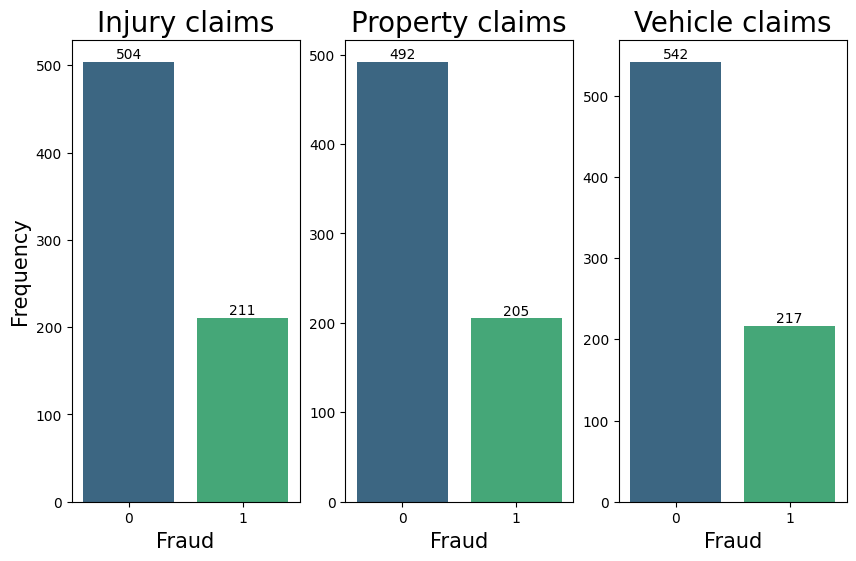

In [23]:
'''
Creating visualization of the distribution of Frauds and Non Frauds per
type of claim.
'''

injury_fraud = df.groupby(['injury_claim', 'fraud_reported']).size().reset_index(name='counts')
property_fraud = df.groupby(['property_claim', 'fraud_reported']).size().reset_index(name='counts')
vehicle_fraud = df.groupby(['vehicle_claim', 'fraud_reported']).size().reset_index(name='counts')

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=charts_figsize_config)
injury = sns.countplot(data=injury_fraud, x='fraud_reported', ax=ax1, palette=charts_palette_color)
ax1.set_title('Injury claims', fontdict=charts_font_config['title'])
ax1.set_xlabel('Fraud', fontdict=charts_font_config['label'])
ax1.set_ylabel('Frequency', fontdict=charts_font_config['label'])
for container in injury.containers:
    injury.bar_label(container)
    
property_ = sns.countplot(data=property_fraud, x='fraud_reported', ax=ax2, palette=charts_palette_color)
ax2.set_title('Property claims', fontdict=charts_font_config['title'])
ax2.set_xlabel('Fraud', fontdict=charts_font_config['label'])
ax2.set_ylabel('')
for container in property_.containers:
    property_.bar_label(container)

vehicle = sns.countplot(data=vehicle_fraud, x='fraud_reported', ax=ax3, palette=charts_palette_color)
ax3.set_title('Vehicle claims', fontdict=charts_font_config['title'])
ax3.set_xlabel('Fraud', fontdict=charts_font_config['label'])
ax3.set_ylabel('')
for container in vehicle.containers:
    vehicle.bar_label(container)

In [24]:
df.head(10)

months_as_customer  age  policy_number  policy_state  policy_deductable  \
0                 328   48         521585           319               1000   
1                 228   42         342868           280               2000   
2                 134   29         687698           319               2000   
3                 256   41         227811           310               2000   
4                 256   39         104594           319               1000   
5                 137   34         413978           280               1000   
6                 165   37         429027           310               1000   
7                  27   33         485665           310                500   
8                 212   42         636550           310                500   
9                 235   42         543610           319                500   

   policy_annual_premium  umbrella_limit  insured_zip  insured_sex  \
0                1406.91               0       466132            1   
1                1197.22         5000000       468176            1   
2                1413.14         5000000       430632            0   
3                1415.74         6000000       608117            0   
4                1351.10               0       478456            0   
5                1333.35               0       441716            1   
6                1137.03               0       603195            1   
7                1442.99               0       601734            0   
8                1315.68               0       600983            1   
9                1253.12         4000000       462283            0   

   insured_education_level  insured_occupation  insured_hobbies  \
0                      132                  70               38   
1                      132                  87               58   
2                      115                  70               43   
3                      115                  59               43   
4                      115                  71               52   
5                      115                  77               43   
6                      129                  71               43   
7                      115                  61               47   
8                      115                  66               50   
9                      130                  68               40   

   insured_relationship  capital-gains  capital-loss  incident_type  \
0                   156          53300             0            403   
1                   164              0             0             53   
2                   165          35100             0            419   
3                   129          48900        -62400            403   
4                   129              0             0            419   
5                   156              0        -77000            419   
6                   129              0             0            419   
7                   165              0             0            403   
8                   139              0        -39300            403   
9                   164          38400             0            403   

   collision_type  incident_severity  authorities_contacted  incident_state  \
0             276                276                    292             225   
1              87                304                    292              96   
2             292                304                    292             246   
3             254                276                    292              20   
4             292                276                    223             225   
5             254                304                    292             246   
6             254                280                    292              96   
7             254                280                    292             196   
8             292                280                    198              97   
9             254                280                    292    

/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/3921398281.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=clients,x=clients['age'], palette=charts_palette_color, color='orange')


([<matplotlib.axis.XTick at 0x17612c1d0>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50'),
  Text(55, 0, '55'),
  Text(60, 0, '60'),
  Text(65, 0, '65'),
  Text(70, 0, '70'),
  Text(75, 0, '75'),
  Text(80, 0, '80'),
  Text(85, 0, '85'),
  Text(90, 0, '90'),
  Text(95, 0, '95')])

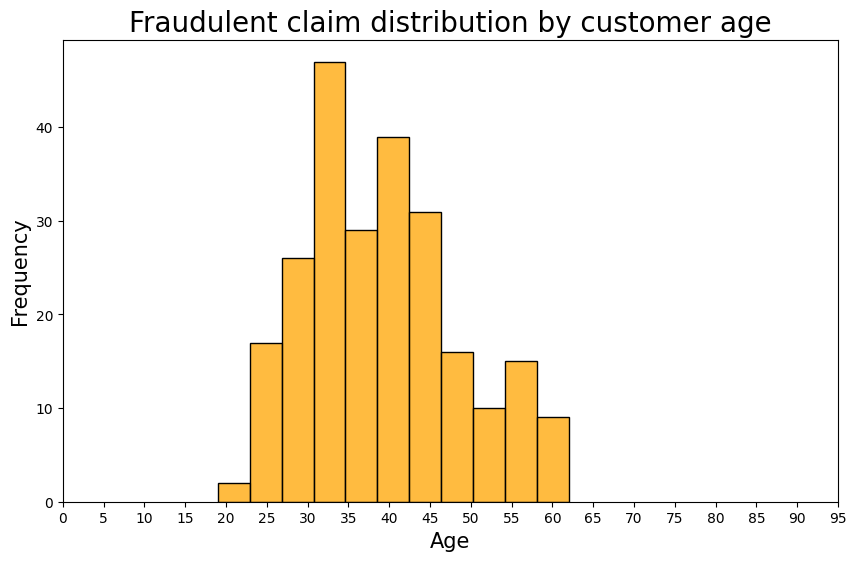

In [25]:
'''
Creating distribution of clients age between fraudulent claims.
'''

figure = plt.figure(figsize=charts_figsize_config)
clients = df[df['fraud_reported'] == 1]

sns.histplot(data=clients,x=clients['age'], palette=charts_palette_color, color='orange')
plt.title('Fraudulent claim distribution by customer age', fontdict=charts_font_config['title'])
plt.xlabel('Age', fontdict=charts_font_config['label'])
plt.ylabel('Frequency', fontdict=charts_font_config['label'])
plt.xticks(range(0, 100, 5))

/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/3194299911.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=auto_year_df, x='auto_year', y='total_claim_amount', palette=charts_palette_color)


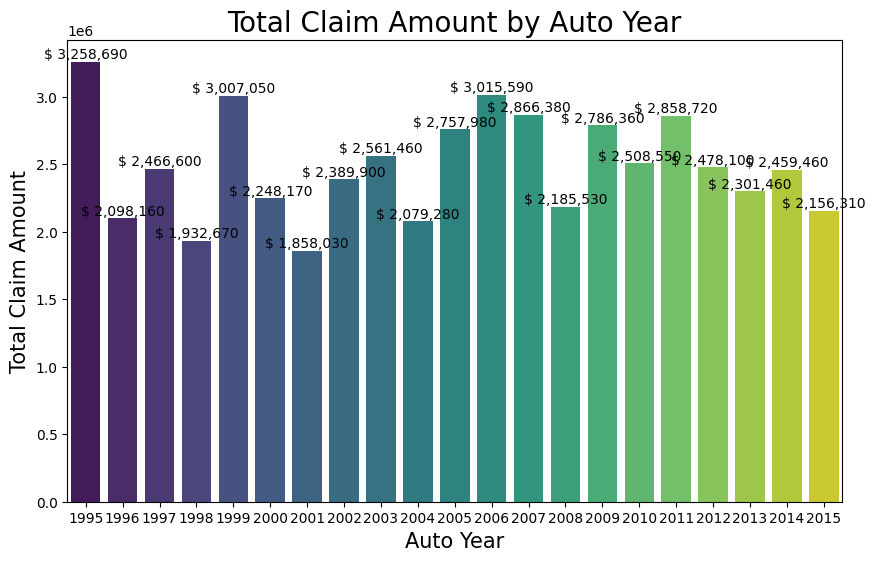

In [26]:
'''
Calculating total claim amount per auto year model.
'''

auto_year_df = df.groupby('auto_year')['total_claim_amount'].sum().reset_index()

figure = plt.figure(figsize=charts_figsize_config)
ax = sns.barplot(data=auto_year_df, x='auto_year', y='total_claim_amount', palette=charts_palette_color)
plt.title('Total Claim Amount by Auto Year', fontdict=charts_font_config['title'])
plt.xlabel('Auto Year', fontdict=charts_font_config['label'])
plt.ylabel('Total Claim Amount', fontdict=charts_font_config['label'])
for container in ax.containers:
    ax.bar_label(container, fmt='$ {:,.0f}')

/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/2845805138.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  auto_year_df = df.groupby('auto_year_range')['total_claim_amount'].sum().reset_index()
/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/2845805138.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=auto_year_df, x='auto_year_range', y='total_claim_amount', palette=charts_palette_color)


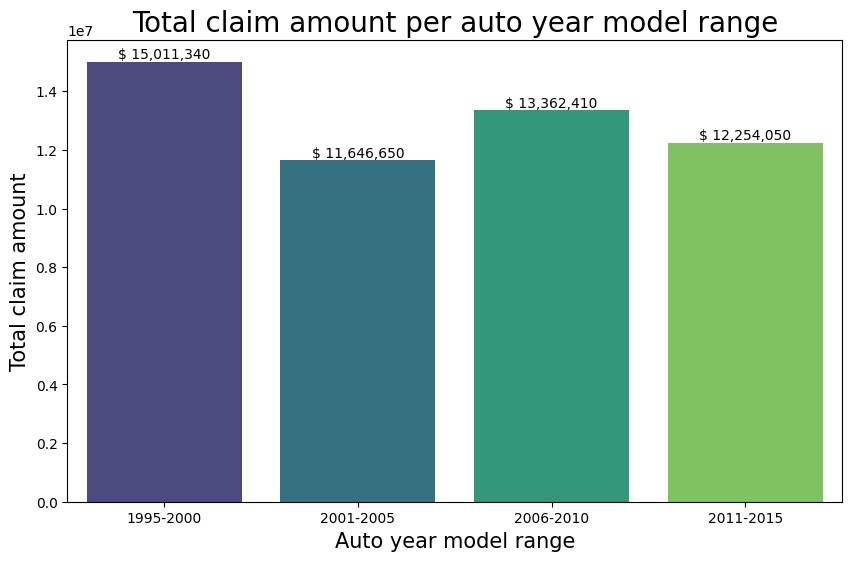

In [27]:
'''
Calculating total claim amoun per range of auto year models. Each
range represents 5 years of models.
'''

bins = [1994, 2000, 2005, 2010, 2015]
labels = ['1995-2000', '2001-2005', '2006-2010', '2011-2015']
df['auto_year_range'] = pd.cut(df['auto_year'], bins=bins, labels=labels)

auto_year_df = df.groupby('auto_year_range')['total_claim_amount'].sum().reset_index()
auto_year_df
figure = plt.figure(figsize=charts_figsize_config)
ax = sns.barplot(data=auto_year_df, x='auto_year_range', y='total_claim_amount', palette=charts_palette_color)
plt.title('Total claim amount per auto year model range', fontdict=charts_font_config['title'])
plt.xlabel('Auto year model range', fontdict=charts_font_config['label'])
plt.ylabel('Total claim amount', fontdict=charts_font_config['label'])
for container in ax.containers:
    ax.bar_label(container, fmt='$ {:,.0f}')

df = df.drop('auto_year_range', axis=1)


/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/2253205287.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df, x='fraud_reported', y='months_as_customer', palette=charts_palette_color)
/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/2253205287.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, alpha=0.3, ax=ax2, palette=charts_palette_color)


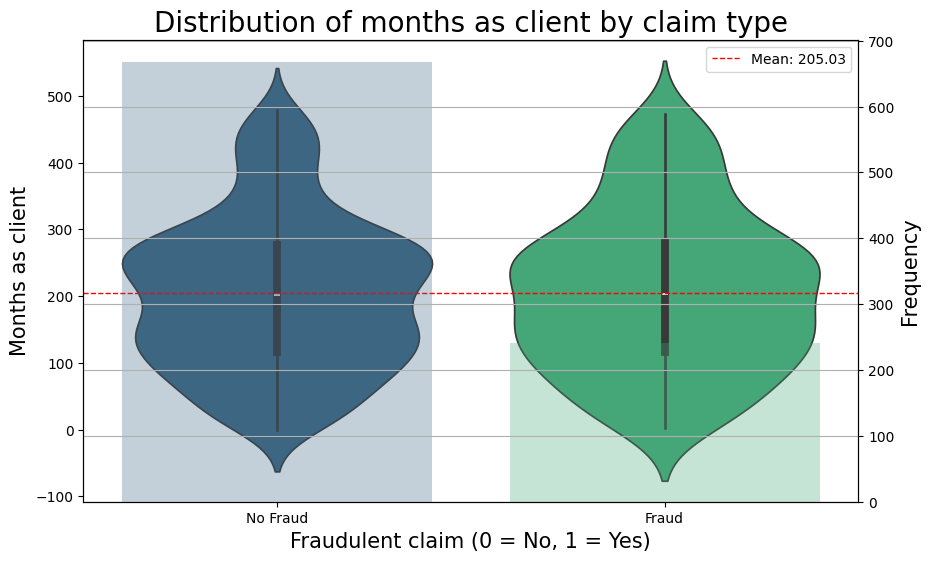

In [28]:
plt.figure(figsize=charts_figsize_config)

ax = sns.violinplot(data=df, x='fraud_reported', y='months_as_customer', palette=charts_palette_color)
plt.title('Distribution of months as client by claim type', fontdict=charts_font_config['title'])
plt.xlabel('Fraudulent claim (0 = No, 1 = Yes)', fontdict=charts_font_config['label'])
plt.ylabel('Months as client', fontdict=charts_font_config['label'])
plt.xticks([0, 1], ['No Fraud', 'Fraud'])
mean_months = df['months_as_customer'].mean()
ax.axhline(mean_months, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_months:.2f}')
plt.legend()

fraud_counts = df['fraud_reported'].value_counts().sort_index()
ax2 = ax.twinx()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, alpha=0.3, ax=ax2, palette=charts_palette_color)
ax2.set_ylabel('Frequency', fontdict=charts_font_config['label'])
ax2.grid(True)

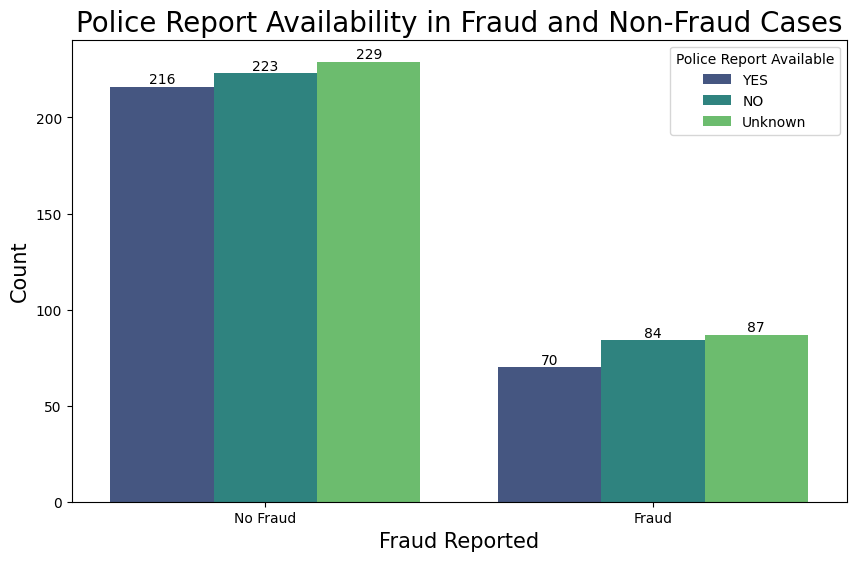

In [29]:
figure = plt.figure(figsize=charts_figsize_config)

combined = pd.crosstab(df['fraud_reported'], df['police_report_available']).reset_index()
combined.columns.name = None
combined = pd.melt(combined, id_vars='fraud_reported', var_name='police_report_available', value_name='count')

# Mapear los valores de 'fraud_reported' a etiquetas más claras
combined['police_report_available'] = combined['police_report_available'].map({316: 'Unknown', 307: 'NO', 286: 'YES'})
combined['fraud_reported'] = combined['fraud_reported'].map({1: 'Fraud', 0: 'No Fraud'})

# Crear el gráfico de barras con Seaborn
ax = sns.barplot(data=combined, x='fraud_reported', y='count', hue='police_report_available', palette=charts_palette_color)

# Configurar el título y las etiquetas
plt.title('Police Report Availability in Fraud and Non-Fraud Cases', fontdict=charts_font_config['title'])
plt.xlabel('Fraud Reported', fontdict=charts_font_config['label'])
plt.ylabel('Count', fontdict=charts_font_config['label'])
plt.legend(title='Police Report Available')



# Añadir etiquetas a las barras
for container in ax.containers:
    ax.bar_label(container)

# Mostrar el gráfico
plt.show()

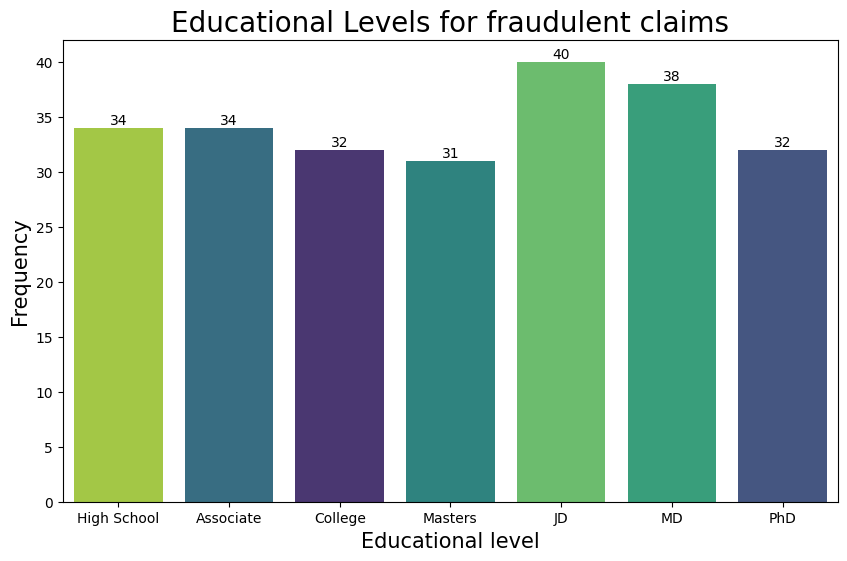

In [30]:
fraud_df = pd.crosstab(df['fraud_reported'], df['insured_education_level']).reset_index()
fraud_df = fraud_df.melt(id_vars='fraud_reported', var_name='insured_education_level', value_name='count')

fraud_df['insured_education_level'] = fraud_df['insured_education_level'].map({
    146: 'High School',
    145: 'JD',
    132: 'MD',
    130: 'Masters',
    129: 'Associate',
    115: 'PhD',
    112: 'College'
})

order = education_levels = [
    "High School",
    "Associate",
    "College",
    "Masters",
    "JD",
    "MD",
    "PhD"
]


figure = plt.figure(figsize=charts_figsize_config)

ax = sns.barplot(data=fraud_df[fraud_df['fraud_reported'] == 1], x='insured_education_level', y='count', hue='insured_education_level', palette=charts_palette_color, order=order)
plt.title('Educational Levels for fraudulent claims', fontdict=charts_font_config['title'])
plt.xlabel('Educational level', fontdict=charts_font_config['label'])
plt.ylabel('Frequency', fontdict=charts_font_config['label'])

for container in ax.containers:
    ax.bar_label(container)


<h3>EDA Insights</h3>
<ol>
<li>Due to the imbalance in the data, predicting 'No Frauds' will be easier than predicting 'Frauds'.</li>
<li>There is a good balance of fraud cases among injury, property, and vehicle claims, indicating that any type of fraud can be properly detected.</li>
<li>Clients aged between 30 and 40 are more likely to file fraudulent claims.</li>
<li>Older auto models, specifically those from 1995 to 2000, incur higher claim premiums.</li>
<li>The longer a client has been with the company, the more likely they are to file a fraudulent claim.</li>
<li>If fraudulent claims tend to lack police reports, this could be a key factor in identifying fraud in future investigations.
The large amount of data in the "Unknown" category may indicate deficiencies in police report records or data quality.</li>
<li>
It seem that the educational level actually has an impact on the likelihood of filing a fraudulent claim. The higher the education level, the more likely the client is to file a fraudulent claim. This could be due to the fact that people with higher education levels are more likely to know how to manipulate the system to their advantage, in this case, people with JD grades, in other words, the lawyers.
<ul>
    <li>High School (Escuela Secundaria)</li>
    <li>Associate (Grado Asociado)</li>
    <li>College (Educación Universitaria, sin especificar grado)</li>
    <li>Masters (Maestría)</li>
    <li>JD (Juris Doctor, grado en Derecho)</li>
    <li>MD (Doctor en Medicina)</li>
    <li>PhD (Doctorado Académico)</li>
</ul>

</li>
</ol>

<h1>3. Data Preparation.</h1>

<h2>Encoding data</h2>


In [31]:
df.head()

months_as_customer  age  policy_number  policy_state  policy_deductable  \
0                 328   48         521585           319               1000   
1                 228   42         342868           280               2000   
2                 134   29         687698           319               2000   
3                 256   41         227811           310               2000   
4                 256   39         104594           319               1000   

   policy_annual_premium  umbrella_limit  insured_zip  insured_sex  \
0                1406.91               0       466132            1   
1                1197.22         5000000       468176            1   
2                1413.14         5000000       430632            0   
3                1415.74         6000000       608117            0   
4                1351.10               0       478456            0   

   insured_education_level  insured_occupation  insured_hobbies  \
0                      132                  70               38   
1                      132                  87               58   
2                      115                  70               43   
3                      115                  59               43   
4                      115                  71               52   

   insured_relationship  capital-gains  capital-loss  incident_type  \
0                   156          53300             0            403   
1                   164              0             0             53   
2                   165          35100             0            419   
3                   129          48900        -62400            403   
4                   129              0             0            419   

   collision_type  incident_severity  authorities_contacted  incident_state  \
0             276                276                    292             225   
1              87                304                    292              96   
2             292                304                    292             246   
3             254                276                    292              20   
4             292                276                    223             225   

   incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
0            141                         5                            1   
1            121                         8                            1   
2            141                         7                            3   
3            129                         5                            1   
4            129                        19                            3   

   property_damage  bodily_injuries  witnesses  police_report_available  \
0              276                1          2                      286   
1              329                0          0                      316   
2              304                2          3                      307   
3              329                1          2                      307   
4              304                0          2                      307   

   total_claim_amount  injury_claim  property_claim  vehicle_claim  auto_make  \
0               71610          6510           13020          52080         72   
1                5070           780             780           3510         60   
2               34650          7700            3850          23100         72   
3               63400          6340            6340          50720         66   
4               64100          6410            6410          51280         72   

   auto_model  auto_year  fraud_reported policy_csl_min policy_csl_max  \
0          24       2004               1            250            500   
1          24       2007               1            250            500   
2          40       2007               0            100            300   
3          22       2014               1            250            500   
4          25       2003               1         

<h2>Outliers</h2>

/var/folders/fq/5zs7fhh97j9fjl57d38bly_c0000gn/T/ipykernel_67541/1824434358.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='fraud_reported', y='age', data=df, palette=charts_palette_color)


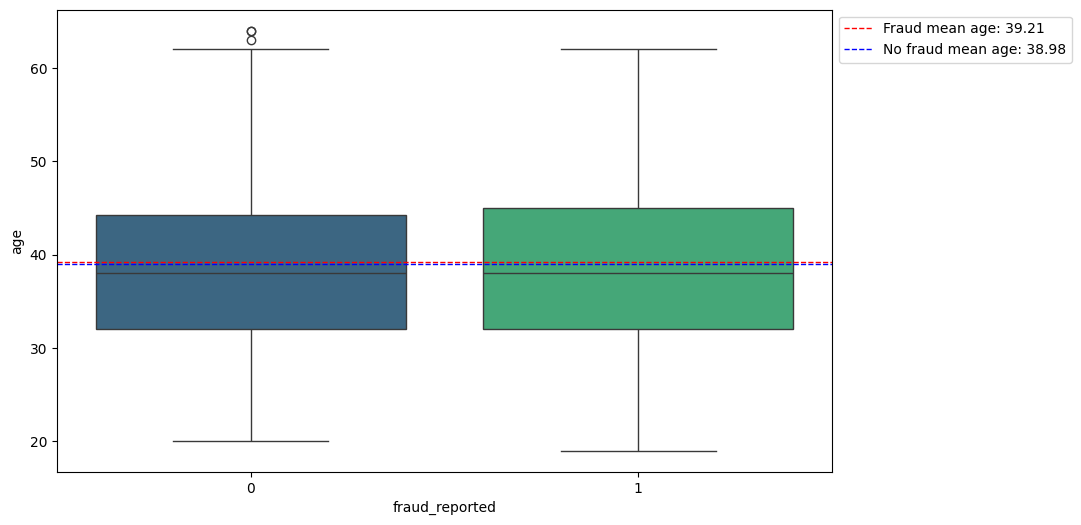

In [32]:
'''
Drawing a boxplot to check for the presence of outliers.
'''

plt.figure(figsize=charts_figsize_config)
ax = sns.boxplot(x='fraud_reported', y='age', data=df, palette=charts_palette_color)
mean_fraud_age = df.loc[df['fraud_reported'] == 1]['age'].mean()
mean_no_fraud_age = df.loc[df['fraud_reported'] == 0]['age'].mean()
ax.axhline(mean_fraud_age, color='red', linestyle='--', linewidth=1, label=f'Fraud mean age: {mean_fraud_age:.2f}')
ax.axhline(mean_no_fraud_age, color='blue', linestyle='--', linewidth=1, label=f'No fraud mean age: {mean_no_fraud_age:.2f}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

<h3>Note: There is no need to apply any outlier deletion process.</h3>

<h2>Dependent variable separation</h2>

In [33]:
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']

<h2>Standardizing data</h2>

In [34]:
'''
Instance of the Scaler object.
'''

scaler = StandardScaler()

In [35]:
'''
Standardizing the dataframe using StandardScaler to ensure 
all features have a mean of 0 and a standard deviation of 1.
'''

df_standarized = scaler.fit_transform(X)

In [36]:
'''
Standardizing the dataframe columns using the previously 
fitted scaler.
'''
df_standarized = pd.DataFrame(data=df_standarized, columns=X.columns)


In [37]:
df_standarized.head(5)

months_as_customer       age  policy_number  policy_state  \
0            1.060663  0.975208      -0.095633      0.920184   
1            0.198143  0.322116      -0.793358     -1.459207   
2           -0.612627 -1.092918       0.552885      0.920184   
3            0.439648  0.213267      -1.242550      0.371094   
4            0.439648 -0.004431      -1.723599      0.920184   

   policy_deductable  policy_annual_premium  umbrella_limit  insured_zip  \
0          -0.214942               0.613265       -0.477722    -0.482463   
1           1.420055              -0.242257        1.717674    -0.453850   
2           1.420055               0.638683        1.717674    -0.979414   
3           1.420055               0.649291        2.156754     1.505131   
4          -0.214942               0.385564       -0.477722    -0.309944   

   insured_sex  insured_education_level  insured_occupation  insured_hobbies  \
0     1.091037                 0.083375            0.352366        -1.349128   
1     1.091037                 0.083375            2.039726         1.878553   
2    -0.916559                -1.327783            0.352366        -0.542208   
3    -0.916559                -1.327783           -0.739455        -0.542208   
4    -0.916559                -1.327783            0.451622         0.910249   

   insured_relationship  capital-gains  capital-loss  incident_type  \
0              0.263009       1.027869      0.952647       0.248789   
1              0.890297      -0.896023      0.952647      -2.996219   
2              0.968709       0.370930      0.952647       0.397132   
3             -1.854089       0.869049     -1.255269       0.248789   
4             -1.854089      -0.896023      0.952647       0.397132   

   collision_type  incident_severity  authorities_contacted  incident_state  \
0        0.333871           0.029739               1.407552        0.577872   
1       -2.970430           0.537395               1.407552       -1.352554   
2        0.613600           0.537395               1.407552        0.892127   
3       -0.050757           0.029739               1.407552       -2.489859   
4        0.613600           0.029739              -0.264001        0.577872   

   incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
0       0.996356                 -1.008772                    -0.895065   
1      -0.938048                 -0.580280                    -0.895065   
2       0.996356                 -0.723110                     1.044420   
3      -0.164286                 -1.008772                    -0.895065   
4      -0.164286                  0.990859                     1.044420   

   property_damage  bodily_injuries  witnesses  police_report_available  \
0        -1.325311        -0.002673   0.466601                -1.408218   
1         1.135266        -1.217440  -1.334420                 1.002914   
2        -0.025384         1.212095   1.367111                 0.279575   
3         1.135266        -0.002673   0.466601                 0.279575   
4        -0.025384        -1.217440   0.466601                 0.279575   

   total_claim_amount  injury_claim  property_claim  vehicle_claim  auto_make  \
0            0.619434     -0.344910        1.088927       0.661039   1.147154   
1           -2.303278     -1.587191       -1.600925      -2.328924  -0.959793   
2           -1.004002     -0.086914       -0.926264      -1.122966   1.147154   
3            0.258817     -0.381766       -0.379064       0.577318   0.093681   
4            0.289563     -0.366590       -0.363681       0.611791   1.147154   

   auto_model  auto_year  policy_csl_min  policy_csl_max  incident_zip  \
0   -0.174730  -0.187267       -0.121686       -0.262180      1.721084   
1   -0.174730   0.311928       -0.121686       -0.262180      0.435369   
2    2.150317   0.311928       -1.051199       -0.960049      0.633617   
3   -0.465361   1.476715       -0.121686       -0.262180      0.569853   
4   -0.029415  -0.3

<h2>Principal features recognition</h2>

<h3>1. K Best</h3>

In [38]:
'''
Instantiating the K-best feature selector and specifying 
a limit of 10 features.
'''

features_total = 10
k_best = SelectKBest(score_func=f_classif, k=features_total)

In [39]:
'''
Training the selector with the dataframe and transforming 
the dataframe.
'''

k_best_x = k_best.fit_transform(X, y)

/Users/noble/opt/anaconda3/envs/fordatascience/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/noble/opt/anaconda3/envs/fordatascience/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [46]:
'''
Getting the name of the features selected using K 
Best algorithm.
'''

k_best_features = k_best.get_support()
k_best_features = list(X.columns[k_best_features])

In [54]:
'''
Listing the names of the selected features.
'''

print('K Best features selected: ')
for index, feature in enumerate(k_best_features, start=1):
    print(f'{index}. {feature}')

K Best features selected: 
1. umbrella_limit
2. insured_hobbies
3. incident_type
4. collision_type
5. authorities_contacted
6. total_claim_amount
7. property_claim
8. vehicle_claim
9. incident_date_timestamp
10. policy_bind_date_day


<h3>2. From Model Selection</h3>

In [ ]:
'''
Instantiating the base model for feature selection.
'''

random_forest_model = RandomForestClassifier()


In [ ]:
'''
Instantiating and training the model selection algorithm.
'''

from_model_selector = SelectFromModel(estimator=random_forest_model)
from_model_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier())

In [ ]:
'''
Retrieving the names of the features selected by the 
selector algorithm.
'''

selected_features_mask = from_model_selector.get_support()
from_model_features = list(X.columns[selected_features_mask])

selected_features_mask = from_model_selector.get_support()
from_model_features = list(X.columns[selected_features_mask])

In [ ]:
'''
Listing the names of the selected features.
'''

print('Model features selected: ')
for index, feature in enumerate(from_model_features, start=1):
    print(f'{index}. {feature}')

Model features selected: 
1. months_as_customer
2. age
3. policy_number
4. policy_annual_premium
5. insured_zip
6. insured_hobbies
7. incident_severity
8. incident_hour_of_the_day
9. total_claim_amount
10. injury_claim
11. property_claim
12. vehicle_claim
13. auto_model
14. auto_year
15. incident_zip
16. policy_bind_date_timestamp
17. incident_date_timestamp
18. policy_bind_date_day
19. incident_date_day


<h3>3. Cross Validation</h3>